<a href="https://colab.research.google.com/github/GeomaticsCaminosUPM/geodataset/blob/main/examples/madrid_private_parking_osm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Madrid OSM private parking dataset

A semantic segmentation tutorial to create a private parking dataset gathering OpenStreetMap data

Colab commands

In [ ]:
#Only execute this cell if you are using google colab
!pip install geopandas
!pip install git+https://github.com/GeomaticsCaminosUPM/geodataset.git
!pip install folium matplotlib mapclassify
!pip install ipyleaflet
# After this restart the session

In [ ]:
import geopandas as gpd
import shapely

from geodataset import GeoDataset, Grid, ImageData, SegmentationData
from geodataset.grid import ipyleaflet_drawable_map
import geodataset.wms
import geodataset.osm

## Dataset bounds


Specified as a [minx,miny,maxx,maxy] bounding box in geographic coords.

In [ ]:
bbox = [-3.70,40.361,-3.69,40.364]
dataset_bounds = gpd.GeoSeries(shapely.box(*bbox),crs=4326)

## Grid creation

Following the same logic as with the Vienna transportation dataset

In [ ]:
img_resolution = (0.3, 0.3)  # 15 cm per pixel (width, height)
img_shape = (512, 512)  # Image shape in pixels (width, height)
tile_overlap = 0.2  # 20% overlap on each side of the grid tiles
tile_in_dataset = 0.5  # 50% of the tile has to be inside the dataset bounds

In [ ]:
grid = Grid(
    dataset_bounds=dataset_bounds,  # Define the dataset bounds
    resolution=img_resolution,      # Define the image resolution (meters per pixel)
    shape=img_shape,                # Define the image shape (pixels)
    overlap=tile_overlap,                # Set the overlap between tiles
    tile_in_dataset=tile_in_dataset # Set the minimum tile coverage within bounds
)

## Images

The input data for an image segmentation geodataset consists of RGB images. These images can come from various sources and formats, which are supported by the library.


Now, let's prepare the dataset using Madrid's government-provided aerial imagery, which can be accessed through a WMS service.

In [ ]:
img_url = 'https://georaster.madrid.es/ApolloCatalogWMSpublic/service.svc/get?service=WMS&version=1.3.0&REQUEST=GetCapabilities&layers=ORTO_2023_10_90'
# The wms link already includes the desired layer. So there is no need to specify that info.

And take a look into the image

In [ ]:
basemap = geodataset.wms.wms_folium_basemap(img_url)
m=dataset_bounds.boundary.explore()
basemap.add_to(m)
m

Layer None not found. Changed to ORTO_2023_10_90


### Image provider object

The image provider object has the method handles requests and crops the image to the desired bounds and resolution.


It's creation follows the same logic already explained in the Vienna transportation dataset tutorial.

In [ ]:
img_obj = geodataset.image.WMS(wms=img_url)
# The wms link already includes the desired layer. So there is no need to specify that info.

Layer None not found. Changed to ORTO_2023_10_90


## Segmentation

In a geoimage segmentation dataset, the ground truth data consists of polygons representing objects, with each polygon assigned an ID corresponding to its semantic class.


We can download the data using overpass turbo api queries. You can prepare your queries here https://overpass-turbo.eu/#

In [ ]:
overpass_query = """
[out:json];
(
  way["amenity"="parking"]({bbox});
  relation["amenity"="parking"]({bbox});
);
(._; >;);
out geom;
"""

Let's check if the request works properly and take a look at the results on a map.


**Note**: Replace `bounds=dataset_bounds` with smaller bounds like the tile 0 `bounds=grid.grid[0:1]` if the request takes too long.

In [ ]:
response = geodataset.osm.overpass_api_query(overpass_query,bounds=dataset_bounds)
response.geometry.explore()

### Segmentation Provider  

To create the segmentation provider object, use `segmentation.OSMPolygon`, which specifies the desired API request. You can configure a `column` and `label_transform_dict`, similar to the Vienna dataset tutorial, or assign a `semantic_class` to all polygons, as demonstrated here.

In [ ]:
seg_obj = geodataset.segmentation.OSMPolygon(overpass_query=overpass_query,semantic_class=1)

## Dataset Object

We can now create a `GeoDataset` object by inputting the image and segmentation providers.

### Key Parameters  

- **`hide_outside=False`:**  
  - OSM will return segmentation data even outside the exact dataset bounds

- **`n_classes`:**  
  - Specifies the number of semantic classes in the dataset.  
  - **Important:** No semantic ID should exceed this value.  

- **`instances=False`:**  
  - Ithe dataset is only semantic.

In [ ]:
ds = GeoDataset(
    grid=grid,
    image=img_obj,
    segmentation=seg_obj,
    n_classes=1,
    instances=False #Our dataset is only semantic
)

Let's take a look at the dataset bounds and tiles

In [ ]:
ds.to_map(mode='grid')

We can visualize specific tiles (e.g., tiles 0, 1, and 2) on a map, including their image, segmentation, and grid boundaries. Remeber that asking for the whole dataset implies many API requests and might take a long time.

In [ ]:
ds.to_map([0,1,2],mode='all')

/usr/local/lib/python3.11/dist-packages/geodataset/geodataset.py:369: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  m=geometry[geometry['semantic_class'] == 0].explore(m=m,color='black',legend=False)


## Plotting one Tile

To visualize tile 0, you can specify the ann_mode to define the annotation format. This represents exactly how the tile of the dataset will look like.

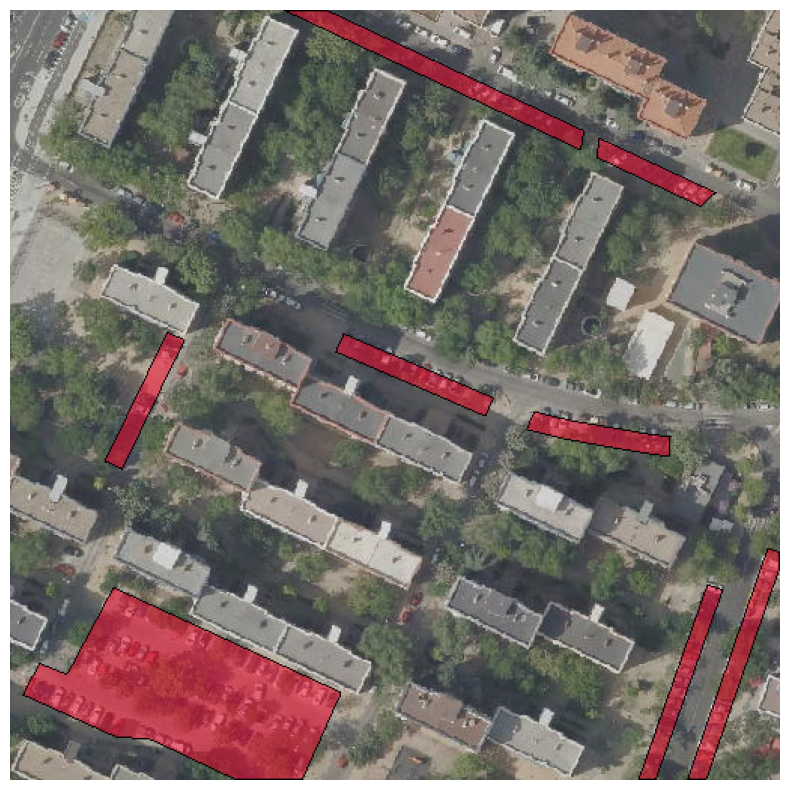

In [ ]:
ds.plot(0,ann_mode='coco')

### Downloading the Dataset  

Before downloading the dataset, you need to select the tiles that you want to download. You can choose the tiles using one of the following methods:

### Methods for Selecting Tiles

1. **Select All Tiles:**

   Use `select_all_tiles()` to select every tile in the dataset.


2. **Select Random Tiles:**

   Use `select_random_tiles(n_tiles)` to randomly select a specified number of tiles (`n_tiles`).


3. **Select Tiles by ID List:**

   Use `select_tiles(tile_id_list)` to select specific tiles by their tile IDs.


4. **Select Tiles within Specific Bounds:**

   Use `select_tiles_in_bounds(bounds:gpd.GeoSeries, how='intersects' or 'contains')` to select tiles based on geographical bounds. You can specify the selection type:
   - `'intersects'`: Select tiles that intersect with the provided bounds.
   - `'contains'`: Select tiles fully contained within the provided bounds.


#### Notes  
- After selecting the tiles, use the `download()` method to save the images and annotations in the desired format.  


In [ ]:
ds.select_all_tiles()

To download the entire dataset, you need to specify the **download paths** and the **annotation format**. In addition, the following parameters are available for customization:

### Parameters  

- **`img_path`:**  
  The path where the images will be saved.  

- **`anns_path`:**  
  The paths where the annotations will be saved.  

- **`ann_mode`:**  
  The annotation format (e.g., `'coco'`, `'raster'`, `'geodataframe'`, `'maskformer'`).

- **`on_errors`** (default: `'ignore'`):  
  Defines the behavior when an error occurs for an image or segmentation provider:
  - `'ignore'`: Skip the tile and continue.
  - `'raise'`: Stop processing when an error occurs and raise it.

- **`overwrite`** (default: `False`):  
  If set to `True`, any existing files will be overwritten.  

- **`allow_empty_anns`** (default: `False`):  
  Specifies whether to allow tiles with no objects in the annotations:
  - `'False'`: Skip the tile if no objects are found (recommended for training).
  - `'True'`: Save the tile even if no objects are present (useful for validation datasets).  

In [ ]:
ds.download(img_path='/content/dataset/images',anns_path='/content/dataset/',ann_mode='coco',allow_empty_anns=False)

Creating image download path /content/dataset/images
Progress: [#] 100% (16/16)Grid tiles saved as /content/dataset/images/grid_tiles.geojson
Grid bounds saved as /content/dataset/images/grid_bounds.geojson
Dataset bounds saved as /content/dataset/images/dataset_bounds.geojson
Grid tiles saved as /content/dataset/grid_tiles.geojson
Grid bounds saved as /content/dataset/grid_bounds.geojson
Dataset bounds saved as /content/dataset/dataset_bounds.geojson
osm overpass query saved as /content/dataset/anns_metadata_0_overpass_query.txt
